# Proyecto EML: 4. Agente de Trading con Reinforcement Learning (Explicado)

Este notebook es una versión detallada del apartado 4, donde no solo implementamos los agentes, sino que **justificamos cada decisión de diseño** basándonos en la teoría de Aprendizaje por Refuerzo (RL).

## ¿Qué vamos a hacer?
Vamos a comparar dos familias de algoritmos fundamentales en Deep RL:
1.  **DQN (Deep Q-Network)**: Un método **basado en valor** (Value-Based). Aprende a estimar el valor $Q(s, a)$ de cada acción y selecciona la que tiene mayor valor esperado. Es ideal para espacios de acción **discretos**.
2.  **PPO (Proximal Policy Optimization)**: Un método **Actor-Crítico** (Policy-Based + Value-Based). Aprende directamente una política $\pi(a|s)$ que mapea estados a probabilidades de acción. Es el estándar actual por su estabilidad y capacidad para manejar espacios de acción **continuos**.

Además, implementamos **Trading Porcentual**, permitiendo al agente decidir *cuánto* comprar o vender, lo cual es más realista que un simple "comprar todo" o "vender todo".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

2025-12-12 21:42:58.963506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Carga y Preparación de Datos

Cargamos los datos procesados anteriormente. Es crucial tener una columna de precio real (o simulado) para calcular el valor del portafolio.

In [2]:
train_path = 'data_processed/GSPC_train.csv'
test_path = 'data_processed/GSPC_test.csv'

df_train = pd.read_csv(train_path, index_col='Date', parse_dates=True)
df_test = pd.read_csv(test_path, index_col='Date', parse_dates=True)

price_col = 'close'

print(f"Usando columna de precio: {price_col}")

Usando columna de precio: close


## 2. Diseño del Entorno (`TradingEnv`)

Aquí es donde definimos las reglas del juego. Heredamos de `gymnasium.Env`, la interfaz estándar para RL.

### Decisiones Clave:
1.  **Espacio de Observación (Estado)**:
    *   Incluimos indicadores técnicos (`rsi`, `volatility`, etc.) porque contienen información predictiva.
    *   **Importante**: Añadimos el *contexto del portafolio* (`shares_held`, `balance`). El agente necesita saber si ya tiene acciones para decidir si vender.
    *   *Normalización*: Normalizamos el balance y las acciones para que estén en rangos similares a los indicadores (cerca de 0-1), facilitando la convergencia de la red neuronal.

2.  **Espacio de Acción**:
    *   **Discreto (DQN)**: DQN selecciona una acción de un conjunto finito. Definimos 5 niveles de agresividad (Hold, Buy 100%, Sell 100%, Buy 50%, Sell 50%).
    *   **Continuo (PPO)**: PPO puede generar un número real. Definimos un rango `[-1, 1]`. Esto permite una granularidad infinita (e.g., comprar el 12.5% del capital).

3.  **Función de Recompensa (Reward)**:
    *   Usamos el **Log Return** del portafolio: $R_t = \log(V_t / V_{t-1})$.
    *   *Por qué?*: Los retornos logarítmicos son simétricos (ganar 10% y perder 10% se cancelan mejor que en aritmético) y aditivos en el tiempo. Maximizar la suma de log-returns equivale a maximizar el valor final del portafolio.

In [3]:
class TradingEnv(gym.Env):
    def __init__(self, df, price_col, initial_balance=10000, fee=0.001, discrete_actions=False):
        super(TradingEnv, self).__init__()
        self.df = df
        self.price_col = price_col
        self.initial_balance = initial_balance
        self.fee = fee
        self.discrete_actions = discrete_actions

        # Features del estado
        self.features = ['rsi', 'volatility', 'dist_sma_60', 'volume'] # usamos close unicamente como precio, no se lo metemos como feature por no estar normalizado
        self.state_columns = self.features

        # Espacio de Observación: Features + Contexto Portafolio
        # Usamos Box para valores continuos (float)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len(self.features) + 2,), dtype=np.float32)

        # Espacio de Acción
        if self.discrete_actions:
            # DQN: Espacio Discreto (5 opciones)
            self.action_space = spaces.Discrete(5)
            self.action_map = {
                0: 0.0,   # Hold
                1: 1.0,   # Buy 100% (All-in)
                2: -1.0,  # Sell 100% (Dump)
                3: 0.5,   # Buy 50%
                4: -0.5   # Sell 50%
            }
        else:
            # PPO: Espacio Continuo (1 valor entre -1 y 1)
            self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.history = []

        return self._get_observation(), {}

    def _get_observation(self):
        # Obtenemos datos del mercado
        obs = self.df.iloc[self.current_step][self.state_columns].values.astype(np.float32)

        current_price = self.df.iloc[self.current_step][self.price_col]

        # Normalización para ayudar a la red neuronal
        # Estimamos un máximo de acciones posible para normalizar entre 0 y 1 aprox.
        max_possible_shares = (self.initial_balance / current_price) * 5
        shares_norm = self.shares_held / max_possible_shares if max_possible_shares > 0 else 0
        balance_norm = self.balance / self.initial_balance

        return np.append(obs, [shares_norm, balance_norm]).astype(np.float32)

    def step(self, action):
        current_price = self.df.iloc[self.current_step][self.price_col]

        # Interpretar acción
        if self.discrete_actions:
            # Si viene como array (común en SB3), extraemos el valor
            if isinstance(action, np.ndarray):
                action = action.item()

            # Aseguramos que sea un entero de Python para usarlo en el diccionario
            action = int(action)

            pct_action = self.action_map[action]
        else:
            # Para PPO (continuo), a veces viene como array de forma (1,)
            if isinstance(action, np.ndarray) and action.shape == (1,):
                pct_action = action[0]
            else:
                pct_action = action
        # Lógica de Trading
        # > 0: Comprar (pct_action * balance)
        # < 0: Vender (abs(pct_action) * shares_held)

        if pct_action > 0.01: # BUY
            amount_to_invest = self.balance * pct_action
            shares_to_buy = (amount_to_invest * (1 - self.fee)) / current_price
            if shares_to_buy > 0:
                self.shares_held += shares_to_buy
                self.balance -= amount_to_invest

        elif pct_action < -0.01: # SELL
            pct_to_sell = abs(pct_action)
            shares_to_sell = self.shares_held * pct_to_sell
            cash_from_sale = shares_to_sell * current_price * (1 - self.fee)
            if shares_to_sell > 0:
                self.balance += cash_from_sale
                self.shares_held -= shares_to_sell

        # Avanzar paso
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        truncated = False

        # Calcular Reward
        next_price = self.df.iloc[self.current_step][self.price_col]
        new_net_worth = self.balance + (self.shares_held * next_price)

        # Reward = Log Return
        # Si el net_worth sube, recompensa positiva. Si baja, negativa.
        reward = np.log(new_net_worth / self.net_worth)

        # Si la acción fue fuerte (>0.5 comprar o <-0.5 vender) Y ganó dinero
        # pct_action es el % que decidió invertir/vender en el step
        if reward > 0 and abs(pct_action) >= 0.5:
            reward *= 1.1  # Le damos un 10% extra de premio por haber sido valiente y acertar

        self.net_worth = new_net_worth
        self.history.append(self.net_worth)

        return self._get_observation(), reward, done, truncated, {}

## 3. Entrenamiento de Agentes

### Hiperparámetros Explicados:
*   `timesteps = 1500000`: Número total de pasos de interacción con el entorno. Más pasos = más aprendizaje, pero más tiempo.
*   `learning_rate`: Velocidad de aprendizaje.
    *   DQN (1e-4): Suele necesitar tasas más bajas para ser estable.
    *   PPO (3e-4): Es más robusto y tolera tasas algo más altas.
*   `buffer_size` (DQN): Memoria de experiencias pasadas. DQN aprende de "replays" aleatorios para romper correlaciones temporales.
*   `exploration_fraction` (DQN): Porcentaje del tiempo que el agente explora aleatoriamente antes de explotar su conocimiento.

In [4]:
# Entorno para DQN (Discreto)
env_dqn = TradingEnv(df_train, price_col=price_col, discrete_actions=True)
env_dqn = Monitor(env_dqn)

# Entorno para PPO (Continuo)
env_ppo = TradingEnv(df_train, price_col=price_col, discrete_actions=False)
env_ppo = Monitor(env_ppo)

# --- CALLBACKS PARA GUARDAR RECOMPENSAS ---
from stable_baselines3.common.callbacks import BaseCallback

class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.rewards = []

    def _on_step(self) -> bool:
        # Registrar recompensa al final de cada episodio
        if self.locals.get("infos"):
            for info in self.locals["infos"]:
                if "episode" in info:
                    self.rewards.append(info["episode"]["r"])
        return True

In [5]:
# DQN: Deep Q-Network
model_dqn = DQN(
    "MlpPolicy",
    env_dqn,
    verbose=0,
    learning_rate=1e-4,
    buffer_size=50000,
    exploration_fraction=0.2
)

# PPO: Proximal Policy Optimization
model_ppo = PPO(
    "MlpPolicy",
    env_ppo,
    verbose=0,
    learning_rate=3e-4
)


# Inicializar Callbacks
callback_dqn = RewardCallback()
callback_ppo = RewardCallback()

# Entrenamiento
timesteps = 1500000
print(f"Entrenando DQN ({timesteps} pasos)...")
model_dqn.learn(total_timesteps=timesteps, callback=callback_dqn, progress_bar=True)

print(f"Entrenando PPO ({timesteps} pasos)...")
model_ppo.learn(total_timesteps=timesteps, callback=callback_ppo, progress_bar=True)

print("Entrenamiento finalizado.")

Output()

Entrenando DQN (1500000 pasos)...


Output()

Entrenando PPO (1500000 pasos)...


Entrenamiento finalizado.


### Celda para guardar los modelos

In [6]:
import os

# Crear directorio para guardar los modelos si no existe
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Guardar los modelos con nombres identificativos
# Se guardan como .zip automáticamente
model_dqn.save(f"{models_dir}/dqn_sp500")
model_ppo.save(f"{models_dir}/ppo_sp500")

print(f"Modelos guardados exitosamente en la carpeta '{models_dir}'")

Modelos guardados exitosamente en la carpeta 'models'


### Celda para cargar los modelos

In [ ]:
from stable_baselines3 import DQN, PPO
import os

models_dir = "models"

# Cargar DQN
# Es recomendable pasar el 'env' al cargar para asegurar la configuración correcta,
# aunque para predicción pura no siempre es estrictamente necesario.
if os.path.exists(f"{models_dir}/dqn_sp500.zip"):
    model_dqn = DQN.load(f"{models_dir}/dqn_sp500", env=env_dqn)
    print("Modelo DQN cargado desde disco.")
else:
    print("ADVERTENCIA: No se encontró el archivo de DQN. Debes entrenarlo primero.")

# Cargar PPO
if os.path.exists(f"{models_dir}/ppo_sp500.zip"):
    model_ppo = PPO.load(f"{models_dir}/ppo_sp500", env=env_ppo)
    print("Modelo PPO cargado desde disco.")
else:
    print("ADVERTENCIA: No se encontró el archivo de PPO. Debes entrenarlo primero.")


Modelo DQN cargado desde disco.
Modelo PPO cargado desde disco.


## 4. Evaluación y Comparativa Detallada

En esta sección evaluamos los modelos en el conjunto de prueba (`df_test`) y generamos gráficas detalladas para entender su comportamiento.

### Explicación de las Métricas:

1.  **Rentabilidad Total**: El beneficio neto final obtenido sobre el capital inicial (10.000€).
2.  **Ratio de Sharpe**:
    * Mide el **retorno ajustado al riesgo**. Nos indica cuánto retorno extra estamos obteniendo por cada unidad de riesgo (volatilidad) que asumimos.
    * *Interpretación*:
        * **< 0**: Malo.
        * **0 - 1**: Regular/Aceptable(Retorno positivo, pero ineficiente respecto al riesgo).
        * **> 1.0**: Bueno.
        * **> 2.0**: Muy bueno.
    * *Nota*: Como usamos datos diarios, anualizamos el ratio multiplicando por $\sqrt{252}$ (días de trading al año).

3.  **Maximum Drawdown (MDD)**:
    * Mide la **peor caída posible** desde un máximo histórico en la curva de equidad.
    * Es vital para la gestión del riesgo: una estrategia que gana mucho dinero pero tiene un Drawdown del -60% es psicológicamente insostenible para un inversor.

### Explicación de las Gráficas:

1.  **Curva de Aprendizaje (Entrenamiento)**:
    * **Eje X (Episodios)**: Cantidad de veces que el agente ha jugado todo el historial de entrenamiento.
    * **Eje Y (Recompensa)**: Es la suma de retornos logarítmicos obtenidos en *un solo episodio*. **No es acumulada entre episodios**, sino que muestra "la nota" que saca el agente en cada intento. Si la curva sube, el agente está aprendiendo.

2.  **Evolución del Portafolio (Test)**:
    * **Eje X (Fecha)**: Tiempo real transcurrido (años).
    * **Eje Y (Valor en €)**: Valor total de la cartera partiendo de los 10,000€ iniciales.
    * Esta gráfica **SÍ** representa la recompensa acumulada real del agente en dinero.

3.  **Drawdown (Gestión de Riesgo)**:
    * Esta gráfica muestra el **porcentaje de caída desde el máximo histórico** alcanzado.
    * Es vital para medir el riesgo: una estrategia que gana mucho pero tiene un drawdown del -50% es muy peligrosa.
    * **Objetivo**: Queremos que las líneas estén lo más cerca posible del 0 (parte superior).

In [7]:
# --- FUNCIONES DE MÉTRICAS ---

def calculate_drawdown(equity_curve):
    """Calcula la serie de Drawdown (caída desde el máximo previo)"""
    series = np.array(equity_curve)
    running_max = np.maximum.accumulate(series)
    drawdown = (series - running_max) / running_max
    return drawdown

def calculate_sharpe(equity_curve, risk_free_rate=0.0):
    """
    Calcula el Ratio de Sharpe Anualizado.
    Asumimos 252 días de trading al año.
    """
    # Convertimos la curva de dinero en retornos porcentuales diarios
    returns = pd.Series(equity_curve).pct_change().dropna()

    if returns.std() == 0:
        return 0.0

    mean_return = returns.mean()
    std_return = returns.std()

    # Ratio diario -> Anualizado (multiplicado por raíz de 252)
    sharpe = (mean_return - risk_free_rate) / std_return * np.sqrt(252)
    return sharpe

def evaluate_model(model, df, price_col, discrete, name):
    env = TradingEnv(df, price_col=price_col, discrete_actions=discrete)
    obs, _ = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
    return env.history, env.net_worth


Evaluando en Test...

METRIC          | B&H        | DQN        | PPO       
----------------------------------------
Capital Final   | 15446 €     | 12136 €     | 15355 €
Beneficio %     | 54.5 %     | 21.4 %     | 53.6 %
Sharpe Ratio    | 1.77       | 1.21       | 1.72
Max Drawdown    | -10.3 %    | -9.2 %    | -10.3 %



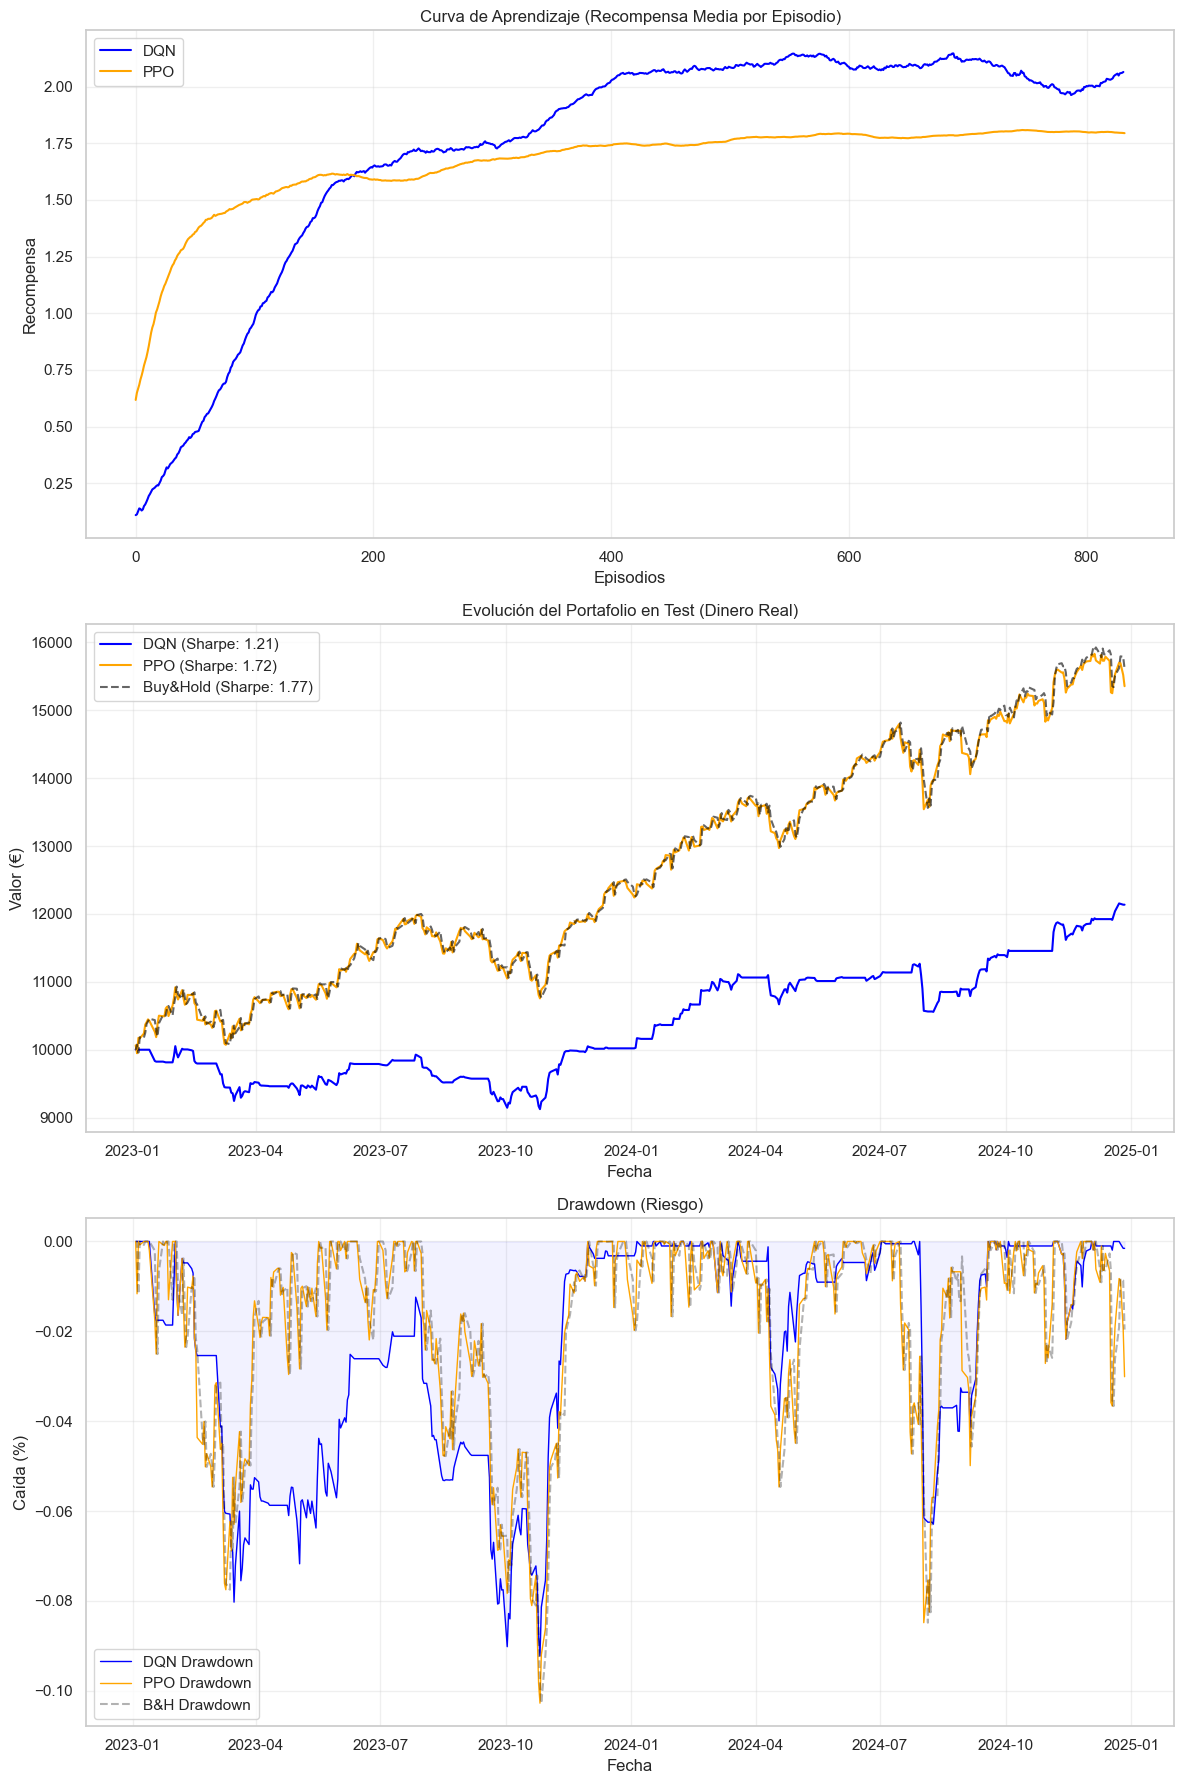

In [8]:
# --- EJECUCIÓN DE LA EVALUACIÓN ---

# 1. Evaluar en TEST
print("Evaluando en Test...")
hist_dqn_test, final_dqn_test = evaluate_model(model_dqn, df_test, price_col, True, "DQN")
hist_ppo_test, final_ppo_test = evaluate_model(model_ppo, df_test, price_col, False, "PPO")

# 2. Calcular Buy & Hold
initial_price = df_test.iloc[0][price_col]
buy_hold_curve = [10000 * (p / initial_price) for p in df_test[price_col].values]
final_bh = buy_hold_curve[-1]

# 3. Calcular Métricas (Sharpe y Max Drawdown)
sharpe_dqn = calculate_sharpe(hist_dqn_test)
sharpe_ppo = calculate_sharpe(hist_ppo_test)
sharpe_bh = calculate_sharpe(buy_hold_curve)

mdd_dqn = calculate_drawdown(hist_dqn_test).min() * 100
mdd_ppo = calculate_drawdown(hist_ppo_test).min() * 100
mdd_bh = calculate_drawdown(buy_hold_curve).min() * 100

# 4. Imprimir Tabla de Resultados
print(f"\n{'='*40}")
print(f"{'METRIC':<15} | {'B&H':<10} | {'DQN':<10} | {'PPO':<10}")
print(f"{'-'*40}")
print(f"{'Capital Final':<15} | {final_bh:.0f} €     | {final_dqn_test:.0f} €     | {final_ppo_test:.0f} €")
print(f"{'Beneficio %':<15} | {(final_bh/10000 - 1)*100:.1f} %     | {(final_dqn_test/10000 - 1)*100:.1f} %     | {(final_ppo_test/10000 - 1)*100:.1f} %")
print(f"{'Sharpe Ratio':<15} | {sharpe_bh:.2f}       | {sharpe_dqn:.2f}       | {sharpe_ppo:.2f}")
print(f"{'Max Drawdown':<15} | {mdd_bh:.1f} %    | {mdd_dqn:.1f} %    | {mdd_ppo:.1f} %")
print(f"{'='*40}\n")


# --- GRÁFICAS ---

# Preparamos datos temporales
fechas = df_test.index[:len(hist_dqn_test)]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# PANEL 1: Curva de Aprendizaje
def moving_average(values, window=50):
    if len(values) < window: return values
    return np.convolve(values, np.ones(window)/window, mode='valid')

if len(callback_dqn.rewards) > 0:
    ax1.plot(moving_average(callback_dqn.rewards), label='DQN', color='blue')
if len(callback_ppo.rewards) > 0:
    ax1.plot(moving_average(callback_ppo.rewards), label='PPO', color='orange')
ax1.set_title("Curva de Aprendizaje (Recompensa Media por Episodio)")
ax1.set_xlabel("Episodios")
ax1.set_ylabel("Recompensa")
ax1.legend()
ax1.grid(True, alpha=0.3)

# PANEL 2: Valor del Portafolio
ax2.plot(fechas, hist_dqn_test, label=f'DQN (Sharpe: {sharpe_dqn:.2f})', color='blue')
ax2.plot(fechas, hist_ppo_test, label=f'PPO (Sharpe: {sharpe_ppo:.2f})', color='orange')
ax2.plot(fechas, buy_hold_curve[:len(fechas)], label=f'Buy&Hold (Sharpe: {sharpe_bh:.2f})', linestyle='--', color='black', alpha=0.6)
ax2.set_title("Evolución del Portafolio en Test (Dinero Real)")
ax2.set_ylabel("Valor (€)")
ax2.set_xlabel("Fecha")
ax2.legend()
ax2.grid(True, alpha=0.3)

# PANEL 3: Drawdown
dd_dqn_series = calculate_drawdown(hist_dqn_test)
dd_ppo_series = calculate_drawdown(hist_ppo_test)
dd_bh_series = calculate_drawdown(buy_hold_curve[:len(fechas)])

ax3.plot(fechas, dd_dqn_series, label='DQN Drawdown', color='blue', linewidth=1)
ax3.plot(fechas, dd_ppo_series, label='PPO Drawdown', color='orange', linewidth=1)
ax3.plot(fechas, dd_bh_series, label='B&H Drawdown', color='black', linestyle='--', alpha=0.3)
ax3.fill_between(fechas, dd_dqn_series, 0, color='blue', alpha=0.05)

ax3.set_title("Drawdown (Riesgo)")
ax3.set_ylabel("Caída (%)")
ax3.set_xlabel("Fecha")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.1. Análisis de Resultados (S&P 500)

Observando las gráficas anteriores, podemos extraer conclusiones interesantes sobre el comportamiento de los agentes en un índice bursátil tradicional:

1.  **Convergencia a "Buy & Hold"**: Tanto DQN como PPO han aprendido una estrategia muy similar a la de "Comprar y Mantener". La línea de PPO (naranja) se solapa casi perfectamente con la del Benchmark (negra punteada).
2.  **Racionalidad del Agente**: Esto **NO es un error**, sino un comportamiento racional. En un mercado con una tendencia alcista generalizada (bull market) como el S&P 500 en los últimos años, y con comisiones de por medio, la estrategia matemáticamente óptima suele ser comprar y no moverse. El agente ha descubierto que hacer trading activo (entrar y salir) a menudo destruye valor por las comisiones.
3.  **Estabilidad**: El agente ha aprendido a no perder dinero tontamente, lo cual es un primer paso vital.


## 5. Experimento de Alta Volatilidad: Bitcoin (BTC)

Para poner a prueba la verdadera capacidad de *trading* de nuestros agentes, necesitamos un entorno donde "Comprar y Mantener" sea peligroso.

Vamos a repetir el experimento utilizando **Bitcoin (BTC-USD)**.
* **¿Por qué?**: Bitcoin tiene ciclos de subidas explosivas y caídas drásticas (-70%).
* **Hipótesis**: En este entorno, una estrategia simple de Buy & Hold sufrirá *drawdowns* masivos. Esperamos que el agente de RL aprenda a **vender antes de las caídas** para proteger el capital, superando así al Benchmark en rentabilidad ajustada al riesgo (Sharpe Ratio).

Cargamos los datos de Bitcoin procesados anteriormente y reentrenamos los modelos desde cero.

In [9]:
# 1. Cargar datos de Bitcoin (Previamente procesados en el apartado 2/3)
# Asegúrate de que los archivos existen en la carpeta data_processed
print("Cargando datos de Bitcoin...")
df_train_btc = pd.read_csv('data_processed/BTC-USD_train.csv', parse_dates=['Date'], index_col='Date')
df_test_btc = pd.read_csv('data_processed/BTC-USD_test.csv', parse_dates=['Date'], index_col='Date')

print(f"Datos BTC cargados: Train={len(df_train_btc)}, Test={len(df_test_btc)}")

# 2. Definir columna de precio (normalmente 'close' o 'Close' dependiendo de yfinance/csv)
# Ajustamos a minúsculas por si acaso, igual que hicimos antes
df_train_btc.columns = df_train_btc.columns.str.lower()
df_test_btc.columns = df_test_btc.columns.str.lower()
price_col = 'close'

# 3. Crear Entornos de Entrenamiento para BTC
# Reutilizamos la clase TradingEnv definida anteriormente
env_train_dqn_btc = TradingEnv(df_train_btc, price_col=price_col, discrete_actions=True)
env_train_dqn_btc = Monitor(env_train_dqn_btc)
env_train_dqn_btc = DummyVecEnv([lambda: env_train_dqn_btc])

env_train_ppo_btc = TradingEnv(df_train_btc, price_col=price_col, discrete_actions=False)
env_train_ppo_btc = Monitor(env_train_ppo_btc)
env_train_ppo_btc = DummyVecEnv([lambda: env_train_ppo_btc])

print("Entornos de Bitcoin listos.")

Cargando datos de Bitcoin...
Datos BTC cargados: Train=2498, Test=730
Entornos de Bitcoin listos.


In [10]:
# --- CONFIGURACIÓN DEL ENTRENAMIENTO (BTC) ---
TIMESTEPS_BTC = 1500000

# Inicializar Callbacks para guardar las recompensas (Igual que en S&P 500)
callback_dqn_btc = RewardCallback()
callback_ppo_btc = RewardCallback()

# 1. Modelo DQN (Bitcoin)
print(f"\nEntrenando DQN en Bitcoin ({TIMESTEPS_BTC} pasos)...")
model_dqn_btc = DQN("MlpPolicy",
                    env_train_dqn_btc,
                    learning_rate=0.0005,
                    buffer_size=50000,
                    exploration_fraction=0.2,
                    verbose=0)

# Pasamos el callback aquí
model_dqn_btc.learn(total_timesteps=TIMESTEPS_BTC, callback=callback_dqn_btc, progress_bar=True)
print("DQN Bitcoin: Entrenamiento finalizado.")

# 2. Modelo PPO (Bitcoin)
print(f"\nEntrenando PPO en Bitcoin ({TIMESTEPS_BTC} pasos)...")
model_ppo_btc = PPO("MlpPolicy",
                    env_train_ppo_btc,
                    learning_rate=0.0003,
                    verbose=0)

# Pasamos el callback aquí
model_ppo_btc.learn(total_timesteps=TIMESTEPS_BTC, callback=callback_ppo_btc, progress_bar=True)
print("PPO Bitcoin: Entrenamiento finalizado.")


Entrenando DQN en Bitcoin (1500000 pasos)...


Output()

Output()

DQN Bitcoin: Entrenamiento finalizado.

Entrenando PPO en Bitcoin (1500000 pasos)...


PPO Bitcoin: Entrenamiento finalizado.


### Celda para guardar los modelos

In [11]:
import os

# Crear directorio para guardar los modelos si no existe
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Guardar los modelos con nombres identificativos
# Se guardan como .zip automáticamente
model_dqn_btc.save(f"{models_dir}/dqn_btc")
model_ppo_btc.save(f"{models_dir}/ppo_btc")

print(f"Modelos guardados exitosamente en la carpeta '{models_dir}'")

Modelos guardados exitosamente en la carpeta 'models'


### Celda para cargar los modelos

In [ ]:
from stable_baselines3 import DQN, PPO
import os

models_dir = "models"

# Cargar DQN
# Es recomendable pasar el 'env' al cargar para asegurar la configuración correcta,
# aunque para predicción pura no siempre es estrictamente necesario.
if os.path.exists(f"{models_dir}/dqn_btc.zip"):
    model_dqn = DQN.load(f"{models_dir}/dqn_btc", env=env_dqn)
    print("Modelo DQN cargado desde disco.")
else:
    print("ADVERTENCIA: No se encontró el archivo de DQN. Debes entrenarlo primero.")

# Cargar PPO
if os.path.exists(f"{models_dir}/ppo_btc.zip"):
    model_ppo = PPO.load(f"{models_dir}/ppo_btc", env=env_ppo)
    print("Modelo PPO cargado desde disco.")
else:
    print("ADVERTENCIA: No se encontró el archivo de PPO. Debes entrenarlo primero.")


Modelo DQN cargado desde disco.
Modelo PPO cargado desde disco.



--- RESULTADOS EXPERIMENTO BITCOIN ---

METRIC (BTC)    | B&H        | DQN        | PPO       
---------------------------------------------
Capital Final   | 55725 €     | 20044 €     | 33628 €
Rentabilidad %  | 457.2 %     | 100.4 %     | 236.3 %
Sharpe Ratio    | 1.66       | 1.08       | 1.52
Max Drawdown    | -26.2 %    | -30.1 %    | -19.2 %



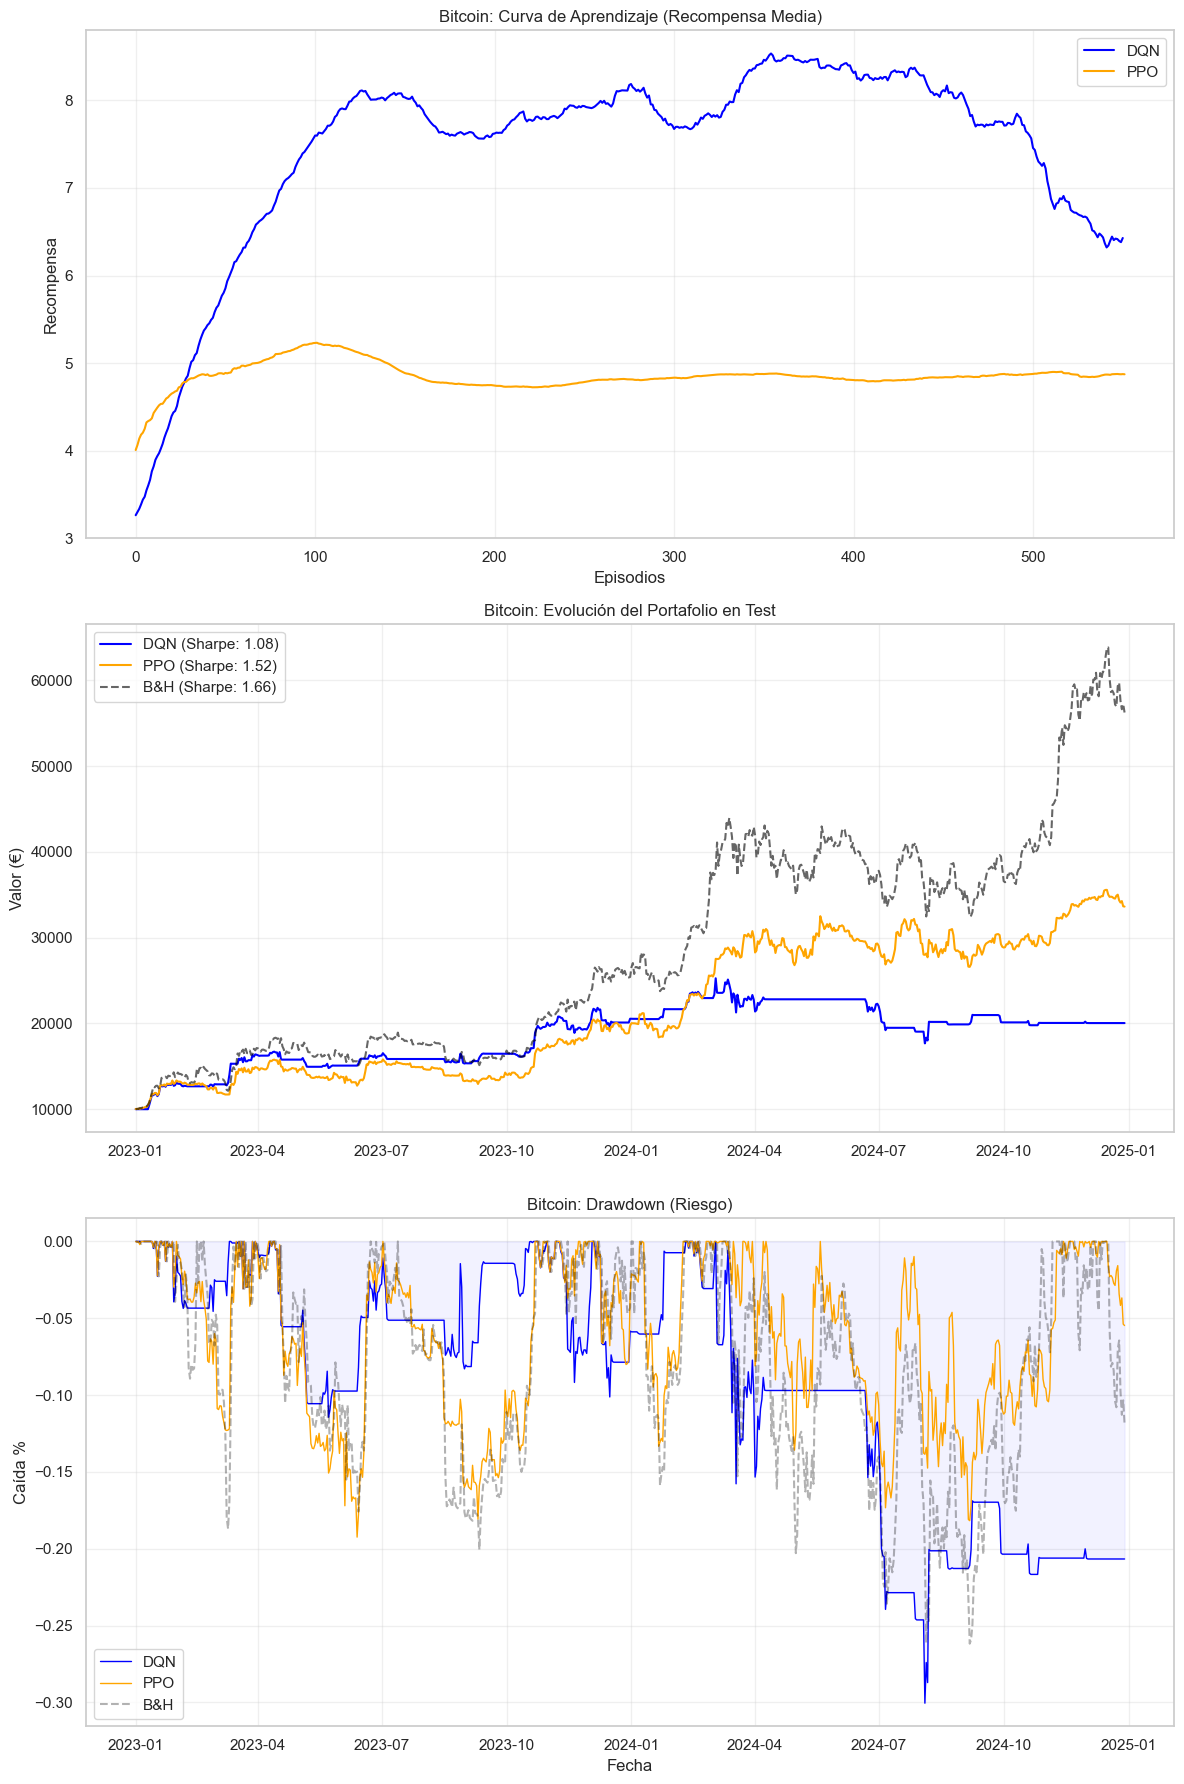

In [12]:
print("\n--- RESULTADOS EXPERIMENTO BITCOIN ---")

# 1. Evaluar en TEST (Bitcoin)
hist_dqn_btc, final_dqn_btc = evaluate_model(model_dqn_btc, df_test_btc, price_col, True, "DQN-BTC")
hist_ppo_btc, final_ppo_btc = evaluate_model(model_ppo_btc, df_test_btc, price_col, False, "PPO-BTC")

# 2. Benchmark (Buy & Hold BTC)
initial_price_btc = df_test_btc.iloc[0][price_col]
buy_hold_curve_btc = [10000 * (p / initial_price_btc) for p in df_test_btc[price_col].values]
final_bh_btc = buy_hold_curve_btc[-1]

# 3. Calcular Métricas
sharpe_dqn_btc = calculate_sharpe(hist_dqn_btc)
sharpe_ppo_btc = calculate_sharpe(hist_ppo_btc)
sharpe_bh_btc = calculate_sharpe(buy_hold_curve_btc)

mdd_dqn_btc = calculate_drawdown(hist_dqn_btc).min() * 100
mdd_ppo_btc = calculate_drawdown(hist_ppo_btc).min() * 100
mdd_bh_btc = calculate_drawdown(buy_hold_curve_btc).min() * 100

# 4. Tabla de Resultados
print(f"\n{'='*45}")
print(f"{'METRIC (BTC)':<15} | {'B&H':<10} | {'DQN':<10} | {'PPO':<10}")
print(f"{'-'*45}")
print(f"{'Capital Final':<15} | {final_bh_btc:.0f} €     | {final_dqn_btc:.0f} €     | {final_ppo_btc:.0f} €")
print(f"{'Rentabilidad %':<15} | {(final_bh_btc/10000 - 1)*100:.1f} %     | {(final_dqn_btc/10000 - 1)*100:.1f} %     | {(final_ppo_btc/10000 - 1)*100:.1f} %")
print(f"{'Sharpe Ratio':<15} | {sharpe_bh_btc:.2f}       | {sharpe_dqn_btc:.2f}       | {sharpe_ppo_btc:.2f}")
print(f"{'Max Drawdown':<15} | {mdd_bh_btc:.1f} %    | {mdd_dqn_btc:.1f} %    | {mdd_ppo_btc:.1f} %")
print(f"{'='*45}\n")

# 5. Gráficas BTC (Ahora con 3 paneles)
fechas_btc = df_test_btc.index[:len(hist_dqn_btc)]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# PANEL 1: Curva de Aprendizaje
# Usamos la misma función moving_average definida en el bloque S&P500
if len(callback_dqn_btc.rewards) > 0:
    ax1.plot(moving_average(callback_dqn_btc.rewards), label='DQN', color='blue')
if len(callback_ppo_btc.rewards) > 0:
    ax1.plot(moving_average(callback_ppo_btc.rewards), label='PPO', color='orange')
ax1.set_title("Bitcoin: Curva de Aprendizaje (Recompensa Media)")
ax1.set_xlabel("Episodios")
ax1.set_ylabel("Recompensa")
ax1.legend()
ax1.grid(True, alpha=0.3)

# PANEL 2: Valor del Portafolio
ax2.plot(fechas_btc, hist_dqn_btc, label=f'DQN (Sharpe: {sharpe_dqn_btc:.2f})', color='blue')
ax2.plot(fechas_btc, hist_ppo_btc, label=f'PPO (Sharpe: {sharpe_ppo_btc:.2f})', color='orange')
ax2.plot(fechas_btc, buy_hold_curve_btc[:len(fechas_btc)], label=f'B&H (Sharpe: {sharpe_bh_btc:.2f})', linestyle='--', color='black', alpha=0.6)
ax2.set_title("Bitcoin: Evolución del Portafolio en Test")
ax2.set_ylabel("Valor (€)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# PANEL 3: Drawdown
dd_dqn_btc_series = calculate_drawdown(hist_dqn_btc)
dd_ppo_btc_series = calculate_drawdown(hist_ppo_btc)
dd_bh_btc_series = calculate_drawdown(buy_hold_curve_btc[:len(fechas_btc)])

ax3.plot(fechas_btc, dd_dqn_btc_series, label='DQN', color='blue', linewidth=1)
ax3.plot(fechas_btc, dd_ppo_btc_series, label='PPO', color='orange', linewidth=1)
ax3.plot(fechas_btc, dd_bh_btc_series, label='B&H', color='black', linestyle='--', alpha=0.3)
ax3.fill_between(fechas_btc, dd_dqn_btc_series, 0, color='blue', alpha=0.05)

ax3.set_title("Bitcoin: Drawdown (Riesgo)")
ax3.set_ylabel("Caída %")
ax3.set_xlabel("Fecha")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Experimento con Materias Primas: Gas Natural (UNG)

A continuación, probamos los agentes en un entorno radicalmente distinto: el **United States Natural Gas Fund (UNG)**.

* **Características**: Este ETF rastrea el precio del gas natural. Es conocido por su **alta volatilidad** y por sufrir a menudo depreciación a largo plazo debido a los costes de los contratos de futuros .
* **El Desafío**: Aquí, la estrategia "Comprar y Mantener" suele ser perdedora en periodos largos.
* **Objetivo**: Queremos ver si el agente es capaz de detectar que el activo es peligroso, manteniéndose en liquidez (Hold/Sell) durante las bajadas y operando solo en los picos de demanda.

Cargamos los datos y entrenamos.

In [13]:
# 1. Cargar datos de UNG
print("Cargando datos de UNG (Gas Natural)...")
df_train_ung = pd.read_csv('data_processed/UNG_train.csv', parse_dates=['Date'], index_col='Date')
df_test_ung = pd.read_csv('data_processed/UNG_test.csv', parse_dates=['Date'], index_col='Date')

print(f"Datos UNG cargados: Train={len(df_train_ung)}, Test={len(df_test_ung)}")

# 2. Asegurar nombres de columnas
df_train_ung.columns = df_train_ung.columns.str.lower()
df_test_ung.columns = df_test_ung.columns.str.lower()
price_col = 'close'

# 3. Crear Entornos de Entrenamiento para UNG
# Reutilizamos la clase TradingEnv ya definida
env_train_dqn_ung = TradingEnv(df_train_ung, price_col=price_col, discrete_actions=True)
env_train_dqn_ung = Monitor(env_train_dqn_ung)
env_train_dqn_ung = DummyVecEnv([lambda: env_train_dqn_ung])

env_train_ppo_ung = TradingEnv(df_train_ung, price_col=price_col, discrete_actions=False)
env_train_ppo_ung = Monitor(env_train_ppo_ung)
env_train_ppo_ung = DummyVecEnv([lambda: env_train_ppo_ung])

print("Entornos de UNG listos.")

Cargando datos de UNG (Gas Natural)...
Datos UNG cargados: Train=1703, Test=501
Entornos de UNG listos.


In [14]:
# --- CONFIGURACIÓN DEL ENTRENAMIENTO (UNG) ---
TIMESTEPS_UNG = 1500000

# Inicializar Callbacks
callback_dqn_ung = RewardCallback()
callback_ppo_ung = RewardCallback()

# 1. Modelo DQN (UNG)
print(f"\nEntrenando DQN en UNG ({TIMESTEPS_UNG} pasos)...")
model_dqn_ung = DQN("MlpPolicy",
                    env_train_dqn_ung,
                    learning_rate=0.0005,
                    buffer_size=50000,
                    exploration_fraction=0.2,
                    verbose=0)

model_dqn_ung.learn(total_timesteps=TIMESTEPS_UNG, callback=callback_dqn_ung, progress_bar=True)
print("DQN UNG: Entrenamiento finalizado.")

# 2. Modelo PPO (UNG)
print(f"\nEntrenando PPO en UNG ({TIMESTEPS_UNG} pasos)...")
model_ppo_ung = PPO("MlpPolicy",
                    env_train_ppo_ung,
                    learning_rate=0.0003,
                    verbose=0)

model_ppo_ung.learn(total_timesteps=TIMESTEPS_UNG, callback=callback_ppo_ung, progress_bar=True)
print("PPO UNG: Entrenamiento finalizado.")

Output()


Entrenando DQN en UNG (1500000 pasos)...


Output()

DQN UNG: Entrenamiento finalizado.

Entrenando PPO en UNG (1500000 pasos)...


PPO UNG: Entrenamiento finalizado.


### Celda para guardar los modelos

In [15]:
import os

# Crear directorio para guardar los modelos si no existe
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Guardar los modelos con nombres identificativos
# Se guardan como .zip automáticamente
model_dqn_ung.save(f"{models_dir}/dqn_ung")
model_ppo_ung.save(f"{models_dir}/ppo_ung")

print(f"Modelos guardados exitosamente en la carpeta '{models_dir}'")

Modelos guardados exitosamente en la carpeta 'models'


### Celda para cargar los modelos

In [ ]:
from stable_baselines3 import DQN, PPO
import os

models_dir = "models"

# Cargar DQN
# Es recomendable pasar el 'env' al cargar para asegurar la configuración correcta,
# aunque para predicción pura no siempre es estrictamente necesario.
if os.path.exists(f"{models_dir}/dqn_ung.zip"):
    model_dqn_ung = DQN.load(f"{models_dir}/dqn_ung", env=env_dqn_ung)
    print("Modelo DQN cargado desde disco.")
else:
    print("ADVERTENCIA: No se encontró el archivo de DQN. Debes entrenarlo primero.")

# Cargar PPO
if os.path.exists(f"{models_dir}/ppo_ung.zip"):
    model_ppo_ung = PPO.load(f"{models_dir}/ppo_ung", env=env_ppo_ung)
    print("Modelo PPO cargado desde disco.")
else:
    print("ADVERTENCIA: No se encontró el archivo de PPO. Debes entrenarlo primero.")


Modelo DQN cargado desde disco.
Modelo PPO cargado desde disco.



--- RESULTADOS EXPERIMENTO UNG (GAS NATURAL) ---

METRIC (UNG)    | B&H        | DQN        | PPO       
---------------------------------------------
Capital Final   | 3527 €     | 5593 €     | 10233 €
Rentabilidad %  | -64.7 %     | -44.1 %     | 2.3 %
Sharpe Ratio    | -0.58       | -0.57       | 0.25
Max Drawdown    | -76.4 %    | -58.2 %    | -51.7 %



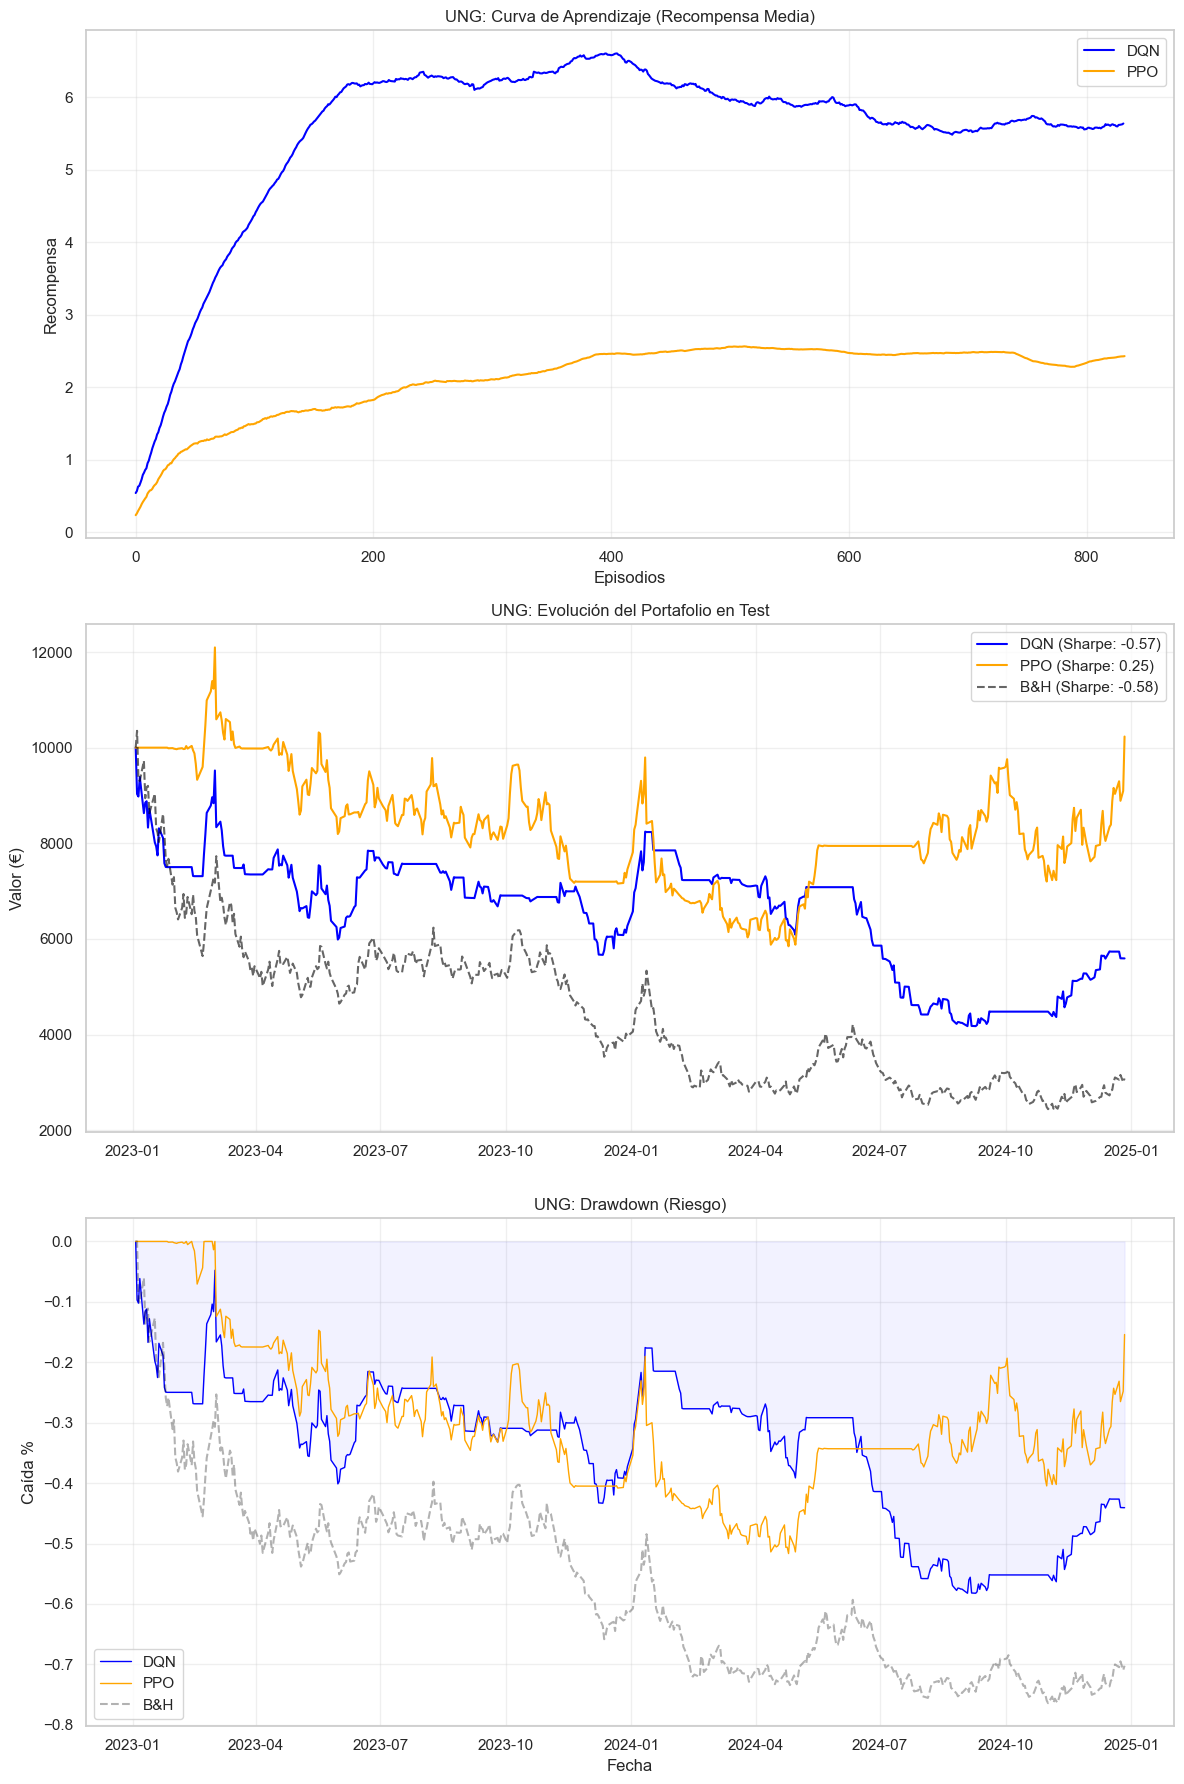

In [16]:
print("\n--- RESULTADOS EXPERIMENTO UNG (GAS NATURAL) ---")

# 1. Evaluar en TEST (UNG)
hist_dqn_ung, final_dqn_ung = evaluate_model(model_dqn_ung, df_test_ung, price_col, True, "DQN-UNG")
hist_ppo_ung, final_ppo_ung = evaluate_model(model_ppo_ung, df_test_ung, price_col, False, "PPO-UNG")

# 2. Benchmark (Buy & Hold UNG)
initial_price_ung = df_test_ung.iloc[0][price_col]
buy_hold_curve_ung = [10000 * (p / initial_price_ung) for p in df_test_ung[price_col].values]
final_bh_ung = buy_hold_curve_ung[-1]

# 3. Calcular Métricas
sharpe_dqn_ung = calculate_sharpe(hist_dqn_ung)
sharpe_ppo_ung = calculate_sharpe(hist_ppo_ung)
sharpe_bh_ung = calculate_sharpe(buy_hold_curve_ung)

mdd_dqn_ung = calculate_drawdown(hist_dqn_ung).min() * 100
mdd_ppo_ung = calculate_drawdown(hist_ppo_ung).min() * 100
mdd_bh_ung = calculate_drawdown(buy_hold_curve_ung).min() * 100

# 4. Tabla de Resultados
print(f"\n{'='*45}")
print(f"{'METRIC (UNG)':<15} | {'B&H':<10} | {'DQN':<10} | {'PPO':<10}")
print(f"{'-'*45}")
print(f"{'Capital Final':<15} | {final_bh_ung:.0f} €     | {final_dqn_ung:.0f} €     | {final_ppo_ung:.0f} €")
print(f"{'Rentabilidad %':<15} | {(final_bh_ung/10000 - 1)*100:.1f} %     | {(final_dqn_ung/10000 - 1)*100:.1f} %     | {(final_ppo_ung/10000 - 1)*100:.1f} %")
print(f"{'Sharpe Ratio':<15} | {sharpe_bh_ung:.2f}       | {sharpe_dqn_ung:.2f}       | {sharpe_ppo_ung:.2f}")
print(f"{'Max Drawdown':<15} | {mdd_bh_ung:.1f} %    | {mdd_dqn_ung:.1f} %    | {mdd_ppo_ung:.1f} %")
print(f"{'='*45}\n")

# 5. Gráficas UNG (3 paneles)
fechas_ung = df_test_ung.index[:len(hist_dqn_ung)]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# PANEL 1: Curva de Aprendizaje
if len(callback_dqn_ung.rewards) > 0:
    ax1.plot(moving_average(callback_dqn_ung.rewards), label='DQN', color='blue')
if len(callback_ppo_ung.rewards) > 0:
    ax1.plot(moving_average(callback_ppo_ung.rewards), label='PPO', color='orange')
ax1.set_title("UNG: Curva de Aprendizaje (Recompensa Media)")
ax1.set_xlabel("Episodios")
ax1.set_ylabel("Recompensa")
ax1.legend()
ax1.grid(True, alpha=0.3)

# PANEL 2: Valor del Portafolio
ax2.plot(fechas_ung, hist_dqn_ung, label=f'DQN (Sharpe: {sharpe_dqn_ung:.2f})', color='blue')
ax2.plot(fechas_ung, hist_ppo_ung, label=f'PPO (Sharpe: {sharpe_ppo_ung:.2f})', color='orange')
ax2.plot(fechas_ung, buy_hold_curve_ung[:len(fechas_ung)], label=f'B&H (Sharpe: {sharpe_bh_ung:.2f})', linestyle='--', color='black', alpha=0.6)
ax2.set_title("UNG: Evolución del Portafolio en Test")
ax2.set_ylabel("Valor (€)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# PANEL 3: Drawdown
dd_dqn_ung_series = calculate_drawdown(hist_dqn_ung)
dd_ppo_ung_series = calculate_drawdown(hist_ppo_ung)
dd_bh_ung_series = calculate_drawdown(buy_hold_curve_ung[:len(fechas_ung)])

ax3.plot(fechas_ung, dd_dqn_ung_series, label='DQN', color='blue', linewidth=1)
ax3.plot(fechas_ung, dd_ppo_ung_series, label='PPO', color='orange', linewidth=1)
ax3.plot(fechas_ung, dd_bh_ung_series, label='B&H', color='black', linestyle='--', alpha=0.3)
ax3.fill_between(fechas_ung, dd_dqn_ung_series, 0, color='blue', alpha=0.05)

ax3.set_title("UNG: Drawdown (Riesgo)")
ax3.set_ylabel("Caída %")
ax3.set_xlabel("Fecha")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()